In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
 85% 204M/239M [00:00<00:00, 756MB/s] 
100% 239M/239M [00:00<00:00, 663MB/s]


In [ ]:
!unzip garbage-classification.zip -d garbage_dataset

Streaming output truncated to the last 5000 lines.
  inflating: garbage_dataset/garbage_classification/paper/paper381.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper382.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper383.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper384.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper385.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper386.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper387.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper388.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper389.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper39.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper390.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper391.jpg  
  inflating: garbage_dataset/garbage_classification/paper/paper392.jpg  
 

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam

# Mapping waste types to biodegradable and non-biodegradable
biodegradable = ['biological', 'paper', 'cardboard', 'clothes']
non_biodegradable = ['plastic', 'metal', 'green-glass', 'brown-glass', 'white-glass', 'battery', 'trash','shoes']

In [ ]:
DATASET_PATH = '/content/garbage_dataset/garbage_classification'

def get_binary_label(folder):
    if folder in biodegradable:
        return 'biodegradable'
    elif folder in non_biodegradable:
        return 'non_biodegradable'
    else:
        return None
filepaths = []
labels = []
for folder in sorted(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        label = get_binary_label(folder)
        if label:
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    filepaths.append(os.path.join(folder_path, fname))
                    labels.append(label)

df_binary = pd.DataFrame({'filepath': filepaths, 'label': labels})
df_binary.head()

,filepath,label
0,/content/garbage_dataset/garbage_classificatio...,non_biodegradable
1,/content/garbage_dataset/garbage_classificatio...,non_biodegradable
2,/content/garbage_dataset/garbage_classificatio...,non_biodegradable
3,/content/garbage_dataset/garbage_classificatio...,non_biodegradable
4,/content/garbage_dataset/garbage_classificatio...,non_biodegradable


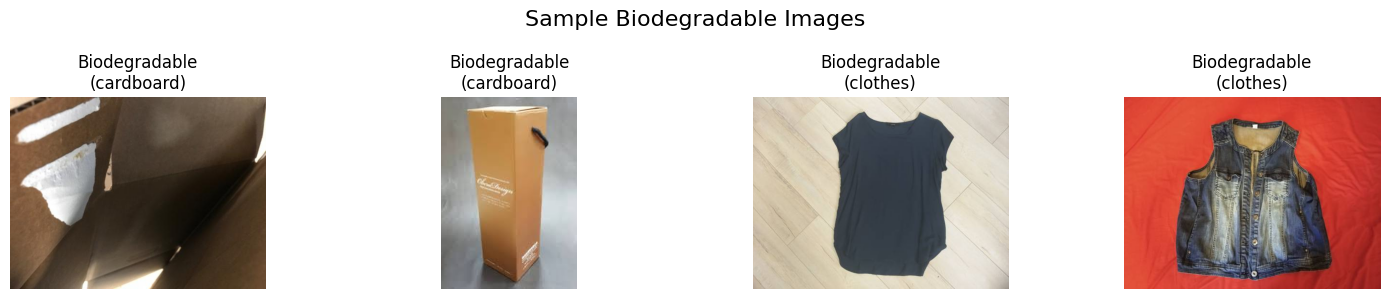

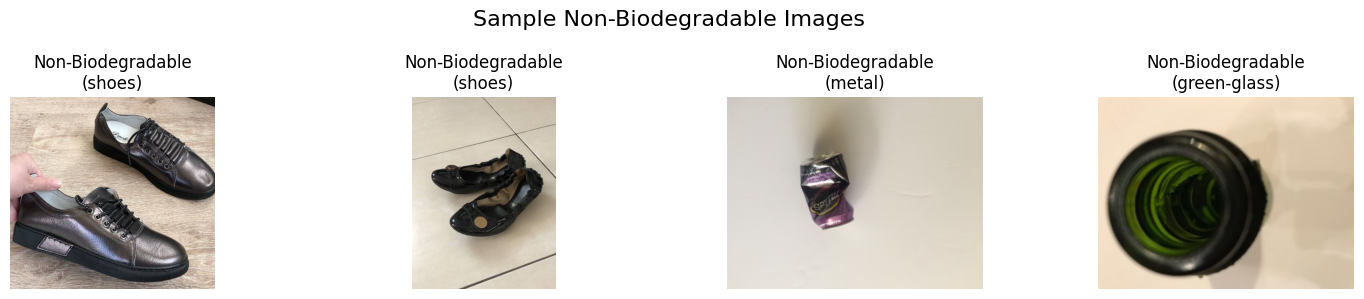

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

no_of_images = 4

def display_random_images(class_list, label):
    plt.figure(figsize=(15,3))
    for i in range(no_of_images):
        # Pick a random category folder from the list
        category = random.choice(class_list)
        folder_path = os.path.join(DATASET_PATH, category)

        # Pick a random image from that folder
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        img_name = random.choice(image_files)
        img_path = os.path.join(folder_path, img_name)

        # Display image
        img = Image.open(img_path)
        plt.subplot(1, no_of_images, i+1)
        plt.imshow(img)
        plt.title(f"{label}\n({category})")
        plt.axis('off')

    plt.suptitle(f"Sample {label} Images", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show samples from each class
display_random_images(biodegradable, "Biodegradable")
display_random_images(non_biodegradable, "Non-Biodegradable")

# **EfficientNetB0(Using Transfer Learning)**

In [ ]:
#Required imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from PIL import Image
import random
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Dataset path
DATASET_PATH = '/content/garbage_dataset/garbage_classification'

# Preprocessing with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [ ]:
# Class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Load EfficientNetB0 base
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Model definition
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='softmax')  # 12 classes
])

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss')
]

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# **ADDING DISPOSAL METHODS FOR WASTE IMAGES**

In [ ]:
waste_info = {
    "plastic": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Check the plastic type and recycle it if possible."
    },
    "metal": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Take it to a metal scrap or recycling center."
    },
    "cardboard": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Recycle or reuse it for packing or crafts."
    },
    "paper": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Keep it dry and put it in the paper recycling bin."
    },
    "clothes": {
        "Reusable": "Yes",
        "Recyclable": "No",
        "Disposal": "Donate if in good condition, or use a textile bin."
    },
    "biological": {
        "Reusable": "No",
        "Recyclable": "No",
        "Disposal": "Compost it or put it in the biodegradable waste bin."
    },
    "battery": {
        "Reusable": "No",
        "Recyclable": "Yes",
        "Disposal": "Drop it at an e-waste collection point safely."
    },
    "trash": {
        "Reusable": "No",
        "Recyclable": "No",
        "Disposal": "Throw it in the general waste bin."
    },
    "shoes": {
        "Reusable": "Yes",
        "Recyclable": "No",
        "Disposal": "Donate if wearable or put in a textile bin."
    },
    "green-glass": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Rinse and put it in the glass recycling bin."
    },
    "brown-glass": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Clean and recycle it if not broken."
    },
    "white-glass": {
        "Reusable": "Yes",
        "Recyclable": "Yes",
        "Disposal": "Recycle or reuse it if it’s in good shape."
    }
}

In [ ]:
#Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 194s 501ms/step - accuracy: 0.8910 - loss: 0.4029 - val_accuracy: 0.9026 - val_loss: 0.3089 - learning_rate: 2.0000e-06
Epoch 2/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 191s 493ms/step - accuracy: 0.8899 - loss: 0.3875 - val_accuracy: 0.9042 - val_loss: 0.2979 - learning_rate: 2.0000e-06
Epoch 3/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 193s 497ms/step - accuracy: 0.8999 - loss: 0.3828 - val_accuracy: 0.9023 - val_loss: 0.3105 - learning_rate: 2.0000e-06
Epoch 4/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 192s 495ms/step - accuracy: 0.8932 - loss: 0.3978 - val_accuracy: 0.9010 - val_loss: 0.2984 - learning_rate: 2.0000e-06
Epoch 5/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 191s 492ms/step - accuracy: 0.8974 - loss: 0.3779 - val_accuracy: 0.9132 - val_loss: 0.2847 - learning_rate: 2.0000e-06
Epoch 6/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 191s 492ms/step - accuracy: 0.9016 - loss: 0.3728 - val_accuracy: 0.9132 - val_loss: 0.2809 - learning_rate: 2.0000e-06
Epoch 7/30
388/388 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Accuracy: {val_acc:.2%}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 37s 378ms/step - accuracy: 0.9322 - loss: 0.2239
Accuracy: 92.94%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


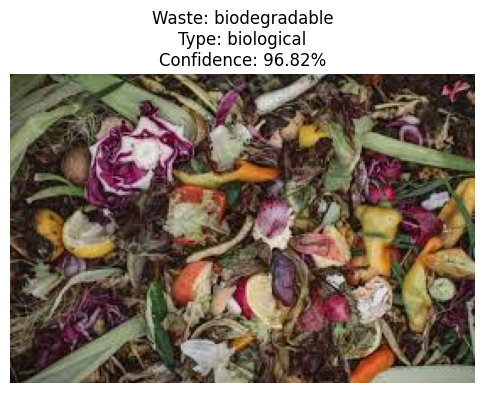

Reusable: No
Recyclable: No
Disposal: Compost it or put it in the biodegradable waste bin.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/bio.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


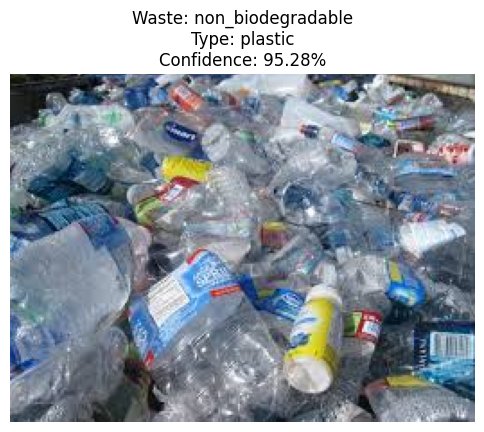

Reusable: Yes
Recyclable: Yes
Disposal: Check the plastic type and recycle it if possible.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/non_2.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


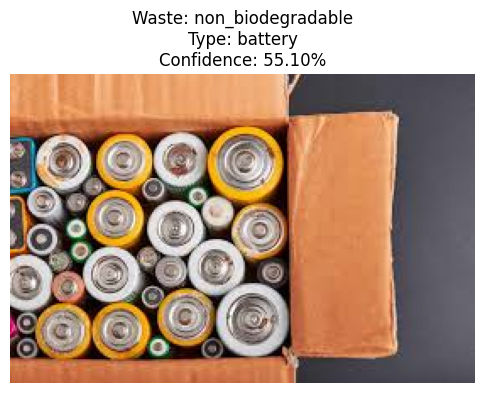

Reusable: No
Recyclable: Yes
Disposal: Drop it at an e-waste collection point safely.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/batery.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


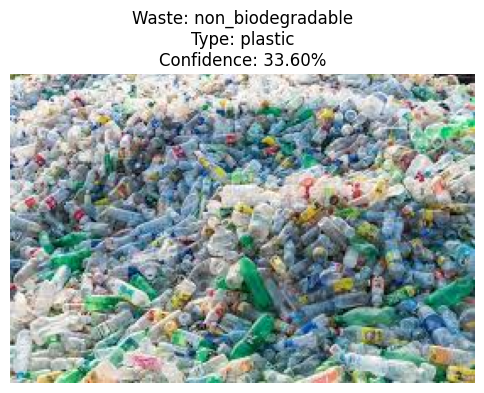

Reusable: Yes
Recyclable: Yes
Disposal: Check the plastic type and recycle it if possible.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/plastic.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


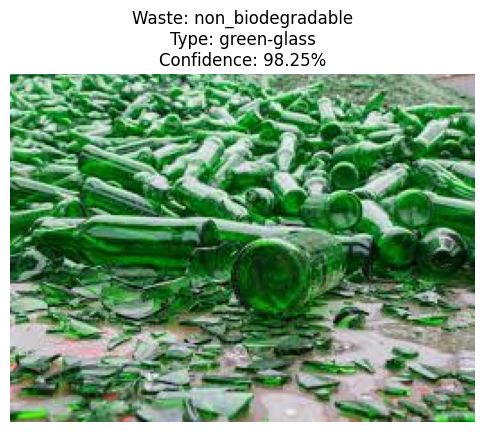

Reusable: Yes
Recyclable: Yes
Disposal: Rinse and put it in the glass recycling bin.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/glass.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


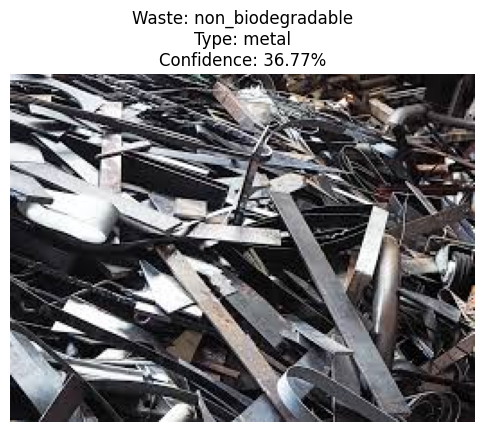

Reusable: Yes
Recyclable: Yes
Disposal: Take it to a metal scrap or recycling center.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/metal.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


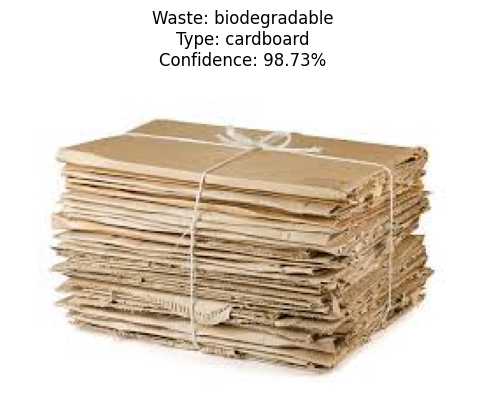

Reusable: Yes
Recyclable: Yes
Disposal: Recycle or reuse it for packing or crafts.


In [ ]:
def predict_and_display(image_path):
    img = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

    img_array = tf.keras.utils.img_to_array(img) / 255.
    img_array = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_array, axis=0)

    class_names = list(train_generator.class_indices.keys())
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    waste_type = class_names[class_idx]
    bio_label = bio_map.get(waste_type, 'non_biodegradable')

    suggestion = waste_info.get(waste_type.lower(), {
        'Reusable': 'Unknown',
        'Recyclable': 'Unknown',
        'Disposal': 'No disposal info available.'
    })

    plt.title(
        f"Waste: {bio_label}\n"
        f"Type: {waste_type}\n"
        f"Confidence: {np.max(pred):.2%}"
    )
    plt.show()

    print("Reusable:", suggestion['Reusable'])
    print("Recyclable:", suggestion['Recyclable'])
    print("Disposal:", suggestion['Disposal'])

    return {
        'waste_type': waste_type,
        'bio/non-bio': bio_label,
        'confidence': float(np.max(pred)),
        'reusable': suggestion['Reusable'],
        'recyclable': suggestion['Recyclable'],
        'disposal': suggestion['Disposal']
    }

result = predict_and_display("/content/cardboard.jpeg")

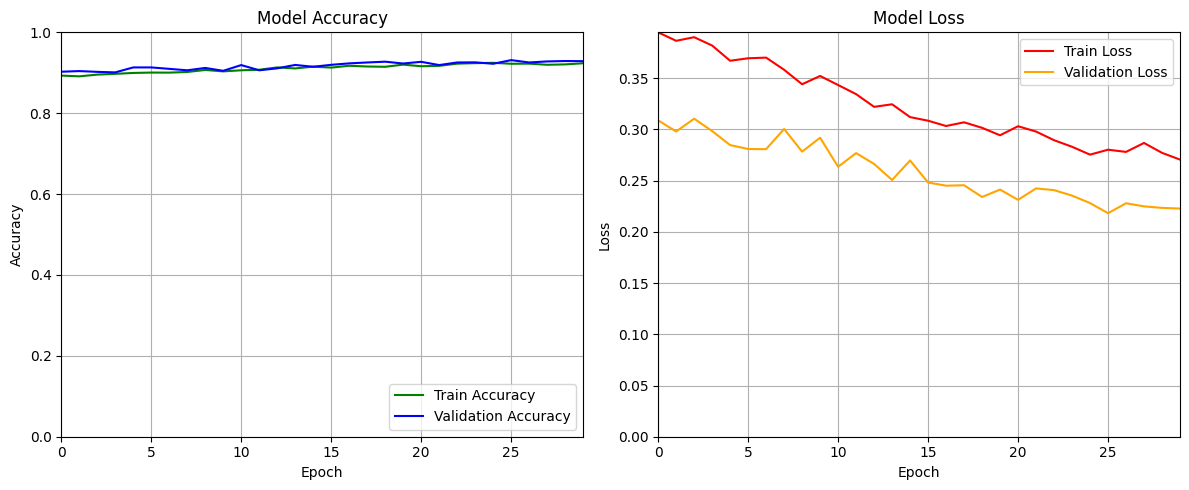

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlim([0, len(history.history['accuracy']) - 1])
plt.ylim([0, 1])

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim([0, len(history.history['loss']) - 1])
plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss']))])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Predict again (you've already done this)
# pred_probs = model.predict(val_generator_fixed, verbose=1)
# y_pred = np.argmax(pred_probs, axis=1)
# y_true = val_generator_fixed.classes

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Print clean output for table entry
print("Model Performance Metrics:")
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Model Performance Metrics:
Validation Accuracy: 92.97%
Precision: 0.93
Recall: 0.93
F1 Score: 0.93


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Get class-wise precision, recall, F1-score
report_dict = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to a DataFrame for a better view
report_df = pd.DataFrame(report_dict).transpose()

# Display only class rows (excluding 'accuracy', 'macro avg', etc.)
class_wise_report = report_df.iloc[:-3][['precision', 'recall', 'f1-score', 'support']]
print(class_wise_report)

             precision    recall  f1-score  support
battery       0.971751  0.910053  0.939891    189.0
biological    0.918269  0.969543  0.943210    197.0
brown-glass   0.927419  0.950413  0.938776    121.0
cardboard     0.940476  0.887640  0.913295    178.0
clothes       0.994269  0.977465  0.985795   1065.0
green-glass   0.928571  0.832000  0.877637    125.0
metal         0.733696  0.882353  0.801187    153.0
paper         0.857778  0.919048  0.887356    210.0
plastic       0.768362  0.786127  0.777143    173.0
shoes         0.969849  0.977215  0.973518    395.0
trash         0.943262  0.956835  0.950000    139.0
white-glass   0.848921  0.761290  0.802721    155.0


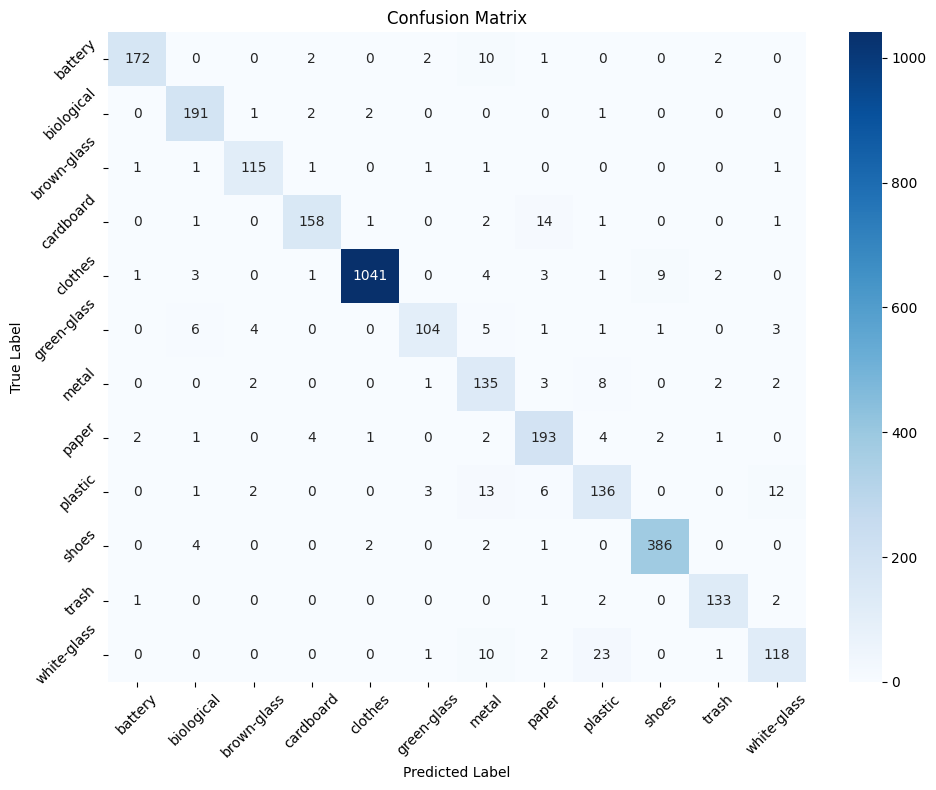

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()